In [1]:
%load_ext autoreload
%autoreload 2
import ipywidgets as widgets
from ipywidgets import HBox, VBox
import gymnasium as gym
from agents import SACAgent2
from omegaconf import DictConfig, OmegaConf
from hydra import compose, initialize
import matplotlib.pyplot as plt
from IPython.display import clear_output
import os
import wandb
import torch as T
from gymnasium.wrappers import RecordVideo
from EnvironmentUtils import LunarEnvHypercubeFabric, LunarEnvRandomFabric, LunarEnvFixedFabric, ValidationHypercube, DetermenisticResetWrapper, RandomWindOnResetWrapper
from agents import SACAgent2, DDPGAgent, SACAgent, PEARLAgent
import numpy as np
from utils import *
os.environ["SDL_VIDEODRIVER"] = "dummy"
import plotly.express as px
import pandas as pd
import shutil
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})

In [2]:
import wandb
api = wandb.Api()
# vanilla pearl best run
#run = api.run("tum-adlr-ws22-06/ADLR randomized envs/2eqd07v7")

In [3]:
#runs = [...]
# for each run:
#     download best model
#     create directory with validation/run_name
#     create hypercube with 5 points
#     for each hypercube point:
#          create subdirectory
#          make run, record video
#          store reward in result array
# make 3d plotly plots with reward as point color
# make nice gifs, comparing sac2 with and without domain parameters

In [4]:
runs = ["tum-adlr-ws22-06/ADLR Unified training/r4vqbtor"]

In [5]:
run = api.run(runs[0])
agent = load_last_model(get_agent_from_run_cfg(run.config), run)

wandb:   6 of 6 files downloaded.  


Last model loaded from .\artifacts\lunar_lander_model-v1629


In [6]:
training_args = run.config['training']
env_args = run.config['env']
validation_args = run.config['validation']

In [7]:
# fabric = LunarEnvHypercubeFabric(pass_env_params=training_args['pass_env_parameters'],
#                                                 render_mode='rgb_array',
#                                                 points_per_axis=validation_args[
#                                                     "hypercube_points_per_axis"], **env_args)

In [8]:
context_size=64

In [10]:

#for run_name in runs:
res = []
#run = api.run(run_name)
folder = f"final_validations/{run.name}_winds"
if os.path.exists(folder):
    shutil.rmtree(folder, ignore_errors=True)
os.mkdir(folder)
print(run.name)
#agent = load_best_model(get_agent_from_run_cfg(run.config), run)
#fabric = LunarEnvHypercubeFabric(run.config['training']['pass_env_parameters'], run.config['env'], points_per_axis=5, render_mode='rgb_array') 
number_points = 3
all_actions = []
all_means = []
all_vars = []
for i in range(number_points):
    env = RandomWindOnResetWrapper(DetermenisticResetWrapper(gym.make('LunarLander-v2', continuous=True,
                                            render_mode='rgb_array', gravity=-11.999,
                                            enable_wind=True, wind_power=10,
                                            turbulence_power=1), seed=0))
    gravity, wind_power, turbulence_power = env.gravity, env.wind_power, env.turbulence_power
    video_path = f"{folder}/{i}_gravity_{gravity}_wind_{wind_power}_turbulence_{turbulence_power}/"
    os.mkdir(video_path)
    env = RecordVideo(env, video_folder=video_path)
    action_list = []
    observation_list = []
    reward_list = []
    z_means_list = []
    z_vars_list = []
    obs, _ = env.reset()
    rewards = 0
    first = True
    while True:

        # Get deterministic action
        with T.no_grad():
            if first:
                action = agent.action(obs, [torch.empty(0, agent.encoder_in_size)], addNoise=False)
                first = False
            else:
                number_of_samples = len(observation_list[-context_size:])
                o_tensor = torch.Tensor(np.array(observation_list [-context_size:])).reshape(number_of_samples, -1)
                a_tensor = torch.Tensor(np.array(action_list[-context_size:])).reshape(number_of_samples, -1)
                r_tensor = torch.Tensor(np.array(reward_list[-context_size:])).reshape(number_of_samples, -1)
                context = torch.cat([o_tensor, a_tensor, r_tensor], dim=1)
                action = agent.action(obs, [context], addNoise=False)
            

        # Take step in environment
        new_obs, reward, done, _, _ = env.step(action)
        action_list.append(action)
        observation_list.append(obs)
        reward_list.append(reward)
        z_means_list.append(agent.z_means)
        z_vars_list.append(agent.z_vars)
        # Update obs
        obs = new_obs

        # Update rewards
        rewards += reward

        # End episode if done
        if done:
            break
    all_actions.append(action_list)
    all_means.append(z_means_list)
    all_vars.append(z_vars_list)
    print(f"gravity: {gravity}, wind_power: {wind_power}, turbulence_power: {turbulence_power}, reward: {rewards}")
    res.append({"gravity": gravity, "wind_power": wind_power, "turbulence_power": turbulence_power, "reward": rewards})
df = pd.DataFrame(res)
df.to_csv(f"{folder}/results.csv", index=False)

pearl2_context_64_metabatch_4


c:\Users\volob\.conda\envs\adlr\lib\site-packages\gymnasium\wrappers\record_video.py:75: UserWarning: WARN: Overwriting existing videos at d:\Desktop\reps\TUM WS22\tum-adlr-ws22-06\final_validations\pearl2_context_64_metabatch_4_winds\0_gravity_-11.999_wind_10_turbulence_1 folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Moviepy - Building video d:\Desktop\reps\TUM WS22\tum-adlr-ws22-06\final_validations\pearl2_context_64_metabatch_4_winds\0_gravity_-11.999_wind_10_turbulence_1\rl-video-episode-0.mp4.
Moviepy - Writing video d:\Desktop\reps\TUM WS22\tum-adlr-ws22-06\final_validations\pearl2_context_64_metabatch_4_winds\0_gravity_-11.999_wind_10_turbulence_1\rl-video-episode-0.mp4



c:\Users\volob\.conda\envs\adlr\lib\site-packages\gymnasium\wrappers\record_video.py:75: UserWarning: WARN: Overwriting existing videos at d:\Desktop\reps\TUM WS22\tum-adlr-ws22-06\final_validations\pearl2_context_64_metabatch_4_winds\1_gravity_-11.999_wind_10_turbulence_1 folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Moviepy - Done !
Moviepy - video ready d:\Desktop\reps\TUM WS22\tum-adlr-ws22-06\final_validations\pearl2_context_64_metabatch_4_winds\0_gravity_-11.999_wind_10_turbulence_1\rl-video-episode-0.mp4
gravity: -11.999, wind_power: 10, turbulence_power: 1, reward: 303.69488335819113
Moviepy - Building video d:\Desktop\reps\TUM WS22\tum-adlr-ws22-06\final_validations\pearl2_context_64_metabatch_4_winds\1_gravity_-11.999_wind_10_turbulence_1\rl-video-episode-0.mp4.
Moviepy - Writing video d:\Desktop\reps\TUM WS22\tum-adlr-ws22-06\final_validations\pearl2_context_64_metabatch_4_winds\1_gravity_-11.999_wind_10_turbulence_1\rl-video-episode-0.mp4



c:\Users\volob\.conda\envs\adlr\lib\site-packages\gymnasium\wrappers\record_video.py:75: UserWarning: WARN: Overwriting existing videos at d:\Desktop\reps\TUM WS22\tum-adlr-ws22-06\final_validations\pearl2_context_64_metabatch_4_winds\2_gravity_-11.999_wind_10_turbulence_1 folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Moviepy - Done !
Moviepy - video ready d:\Desktop\reps\TUM WS22\tum-adlr-ws22-06\final_validations\pearl2_context_64_metabatch_4_winds\1_gravity_-11.999_wind_10_turbulence_1\rl-video-episode-0.mp4
gravity: -11.999, wind_power: 10, turbulence_power: 1, reward: 62.3351450950793
Moviepy - Building video d:\Desktop\reps\TUM WS22\tum-adlr-ws22-06\final_validations\pearl2_context_64_metabatch_4_winds\2_gravity_-11.999_wind_10_turbulence_1\rl-video-episode-0.mp4.
Moviepy - Writing video d:\Desktop\reps\TUM WS22\tum-adlr-ws22-06\final_validations\pearl2_context_64_metabatch_4_winds\2_gravity_-11.999_wind_10_turbulence_1\rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready d:\Desktop\reps\TUM WS22\tum-adlr-ws22-06\final_validations\pearl2_context_64_metabatch_4_winds\2_gravity_-11.999_wind_10_turbulence_1\rl-video-episode-0.mp4
gravity: -11.999, wind_power: 10, turbulence_power: 1, reward: 300.50160727067697


In [14]:
all_actions = [np.array(actions) for actions in all_actions]


In [16]:
#process all means from list of tensorts to np array
all_means = np.array([np.array(m) for m in all_means])
all_vars = np.array([np.array(v) for v in all_vars])

C:\Users\volob\AppData\Local\Temp\ipykernel_16692\816258978.py:2: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  all_means = np.array([np.array(m) for m in all_means])
C:\Users\volob\AppData\Local\Temp\ipykernel_16692\816258978.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  all_means = np.array([np.array(m) for m in all_means])
C:\Users\volob\AppData\Local\Temp\

In [17]:
all_means = all_means.reshape(all_means.shape[0],  -1)
all_vars = all_vars.reshape(all_vars.shape[0],  -1)

In [18]:
df = pd.DataFrame(res)


In [19]:
#adding means and vars to df
df['latent mean 1'] = all_means[:,0]
df['latent mean 2'] = all_means[:,1]
df['latent mean 3'] = all_means[:,2]
df['latent mean 4'] = all_means[:,3]
df['var_0'] = all_vars[:,0]
df['var_1'] = all_vars[:,1]
df['var_2'] = all_vars[:,2]
df['var_3'] = all_vars[:,3]


IndexError: index 1 is out of bounds for axis 1 with size 1

In [ ]:
df['sum_of_vars'] = df['var_0'] + df['var_1'] + df['var_2'] + df['var_3']
df['max_of_vars'] = df[['var_0', 'var_1', 'var_2', 'var_3']].max(axis=1)

In [ ]:
# SHOW HOW PEARL WORKS FOR THE BEST SAC2 CASE, HOW TO WORST
# and, the opposite

In [21]:
task_id = 2

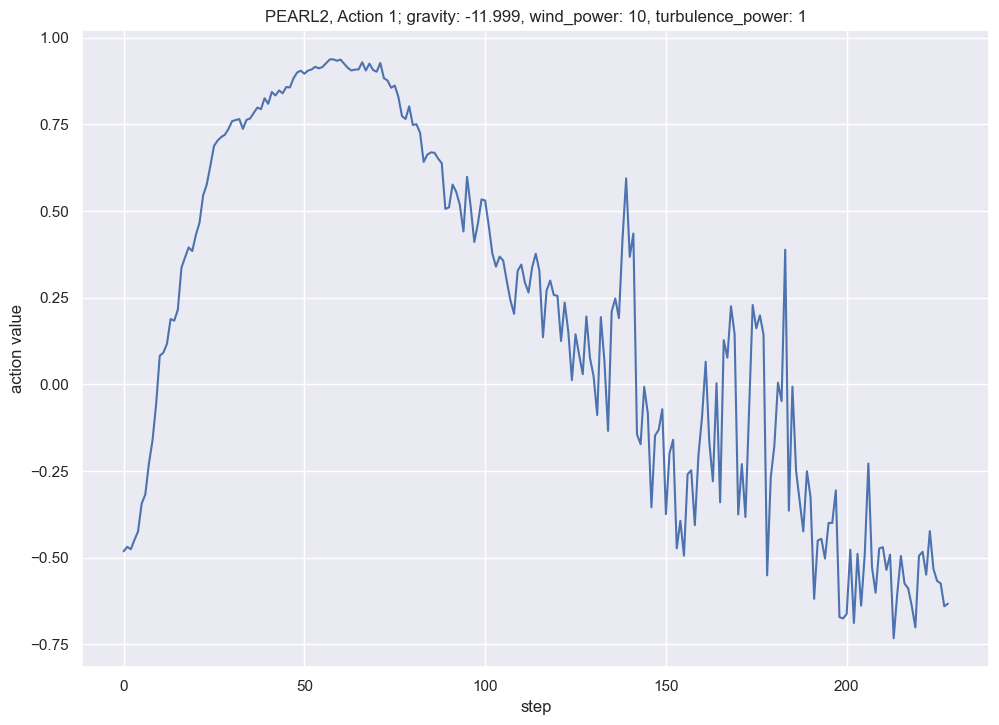

In [22]:
#lineplot of first actions
plt.plot(all_actions[task_id][:, 0]);
#title with env params from df
plt.title(f"PEARL2, Action 1; gravity: {df['gravity'][task_id]}, wind_power: {df['wind_power'][task_id]}, turbulence_power: {df['turbulence_power'][task_id]}");
plt.xlabel('step');
plt.ylabel('action value');
#plt.title("PEARL, Action 1");

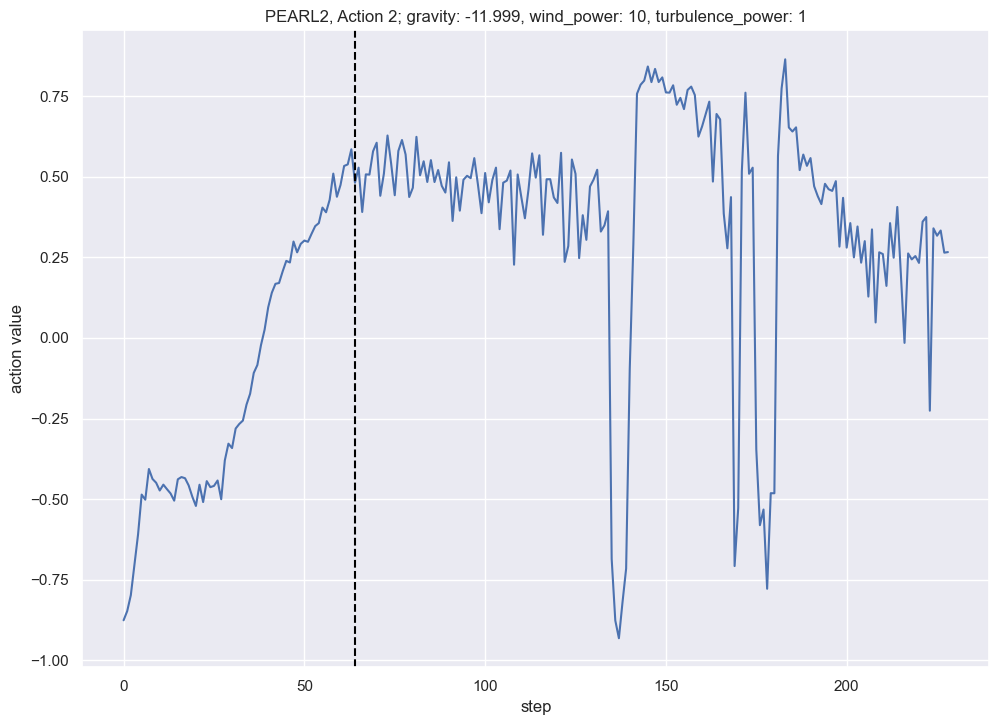

In [24]:
#lineplot of first actions
ax = plt.plot(all_actions[task_id][:, 1]);
plt.axvline(x=64, color='black', linestyle='--');
plt.title(f"PEARL2, Action 2; gravity: {df['gravity'][task_id]}, wind_power: {df['wind_power'][task_id]}, turbulence_power: {df['turbulence_power'][task_id]}");
plt.xlabel('step');
plt.ylabel('action value');

In [31]:
means_task = np.array([m.reshape(-1).detach().numpy() for m in all_means[task_id]])

In [26]:
#convecting means to pandas df with columns
df_means = pd.DataFrame(means_task, columns=['mean_0', 'mean_1', 'mean_2', 'mean_3'])

NameError: name 'means_task' is not defined

In [25]:
#sns plot of means per time
ax = sns.lineplot(data=df_means);
#draw vertical line at 64
ax.axvline(x=64, color='black', linestyle='--');
#x axis label - step
ax.set(xlabel='step', ylabel='latent mean');

NameError: name 'df_means' is not defined

<AxesSubplot: xlabel='max_of_vars', ylabel='reward'>

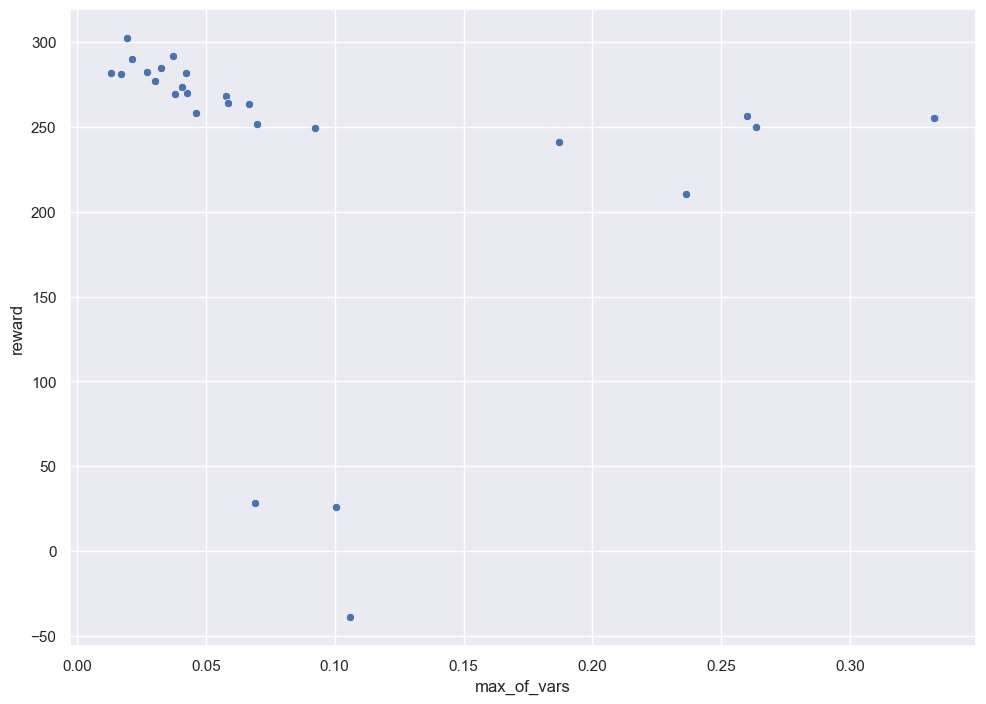

In [61]:
#scatterplot of sum of latent vars vs reward
sns.scatterplot(data=df, x="max_of_vars", y="reward")

In [21]:
fig = px.scatter_3d(df, x='gravity', y='wind_power', z='turbulence_power',
              color='reward')
fig.show()

In [29]:
df

,gravity,wind_power,turbulence_power,reward,latent mean 1,latent mean 2,latent mean 3,latent mean 4,var_0,var_1,var_2,var_3,sum_of_vars,max_of_vars
0,-11.9990,5.0,0.6,291.524183,-0.524507,0.212907,-2.108798,-0.474705,0.001708,0.002211,0.000901,0.001951,0.006771,0.002211
1,-11.9990,5.0,0.8,262.409542,-0.586042,0.204715,-2.277114,-0.543602,0.087840,0.112857,0.044243,0.100371,0.345311,0.112857
2,-11.9990,5.0,1.0,277.575964,-0.615832,0.211906,-2.398802,-0.566640,0.117704,0.150827,0.058099,0.134749,0.461379,0.150827
3,-11.9990,7.5,0.6,24.081558,-0.832723,0.235128,-3.006399,-0.776366,0.261911,0.336455,0.129713,0.300453,1.028531,0.336455
4,-11.9990,7.5,0.8,266.986754,-0.521206,0.196040,-2.092316,-0.495520,0.060162,0.077595,0.031147,0.068661,0.237565,0.077595
5,-11.9990,7.5,1.0,264.389692,-0.661615,0.231326,-2.504723,-0.559708,0.032407,0.041978,0.017332,0.037082,0.128798,0.041978
6,-11.9990,10.0,0.6,37.577457,-0.534394,0.199654,-2.103364,-0.484570,0.090624,0.115792,0.043724,0.103693,0.353834,0.115792
7,-11.9990,10.0,0.8,268.455041,-0.697512,0.218248,-2.626576,-0.639868,0.165192,0.212714,0.084594,0.189119,0.651619,0.212714
8,-11.9990,10.0,1.0,268.472647,-0.662363,0.201878,-2.389832,-0.619937,0.248357,0.318794,0.121787,0.284732,0.973670,0.318794
9,-9.4995,5.0,0.6,286.133984,-0.255376,0.129679,-1.149624,-0.284833,0.030158,0.038329,0.013882,0.034341,0.116709,0.038329


In [7]:
with initialize(version_base=None, config_path="conf"):
    cfg = compose(config_name="config")
    

In [10]:
env_fabric = LunarEnvHypercubeFabric(env_params=cfg.env, pass_env_params=True)
env = env_fabric.generate_env()
env_info = {"input_dims":env.observation_space.shape, "n_actions": env.action_space.shape[0], "max_action": env.action_space.high}

c:\Users\volob\.conda\envs\adlr\lib\site-packages\gymnasium\spaces\box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


In [19]:
@widgets.interact_manual(g=(-12.0, 0.0), wind_power=(0.0, 20.0), turbulence_power=(0.0, 2.0)
                         )
def make_video(g=-10, wind_power=0.0, turbulence_power=0.0, plot_every_action=5):
    env = gym.make('LunarLander-v2', continuous=True, render_mode='rgb_array', gravity=g , enable_wind=True, wind_power=wind_power, 
             turbulence_power=turbulence_power)
    obs, info = env.reset()
    step = 0
    while True:
        action = agent.action(obs, addNoise=False)
        new_obs, reward, done, _, _ = env.step(action)
        if step % plot_every_action == 0:
            clear_output(wait=True)
            plt.imshow( env.render())
            plt.show()
        step += 1
        if done:
            break
    env.close()

interactive(children=(FloatSlider(value=-10.0, description='g', max=0.0, min=-12.0), FloatSlider(value=0.0, de…